In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from skimage import data
from skimage import filters
from skimage import exposure
from skimage import measure
from skimage import segmentation
from skimage import morphology
from skimage import color

In [0]:
os.listdir("../input/oil tanks/Oil Tanks")

['image_patches',
 'large_images',
 'labels_coco.json',
 'large_image_data.csv',
 'labels.json']

In [0]:
path = Path("../input/oil tanks/Oil Tanks")

In [0]:
j = json.load(open(path/'labels.json'))

`conv_bbox` converts bounding boxes from corner coordinates to a `[y_min, x_min, y_max, x_max]` format

In [0]:
def conv_bbox(box_dict):
    
    xs = np.array(list(set([i['x'] for i in box_dict])))
    ys = np.array(list(set([i['y'] for i in box_dict])))
    
    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()
    
    return y_min, x_min, y_max, x_max

The algorithm is designed to work with tanks that are fully in frame. Bounding boxes that reach the edge of an image (indicating the tank extends beyond the image) are excluded from processing.

In [0]:
def check_bb(bbox, shape):
        c, h, w = shape
        
        for d in bbox:
            if d['x'] <= 2 or d['x'] >= w-2:
                return False
            elif d['y'] <=2 or d['y'] >= h-2:
                return False
        return True

`intersection` calculates the pixel area intersection between two bounding boxes

In [0]:
def intersection(bb1, bb2):
    y_min1, x_min1, y_max1, x_max1 = bb1
    y_min2, x_min2, y_max2, x_max2 = bb2
    
    x_left = max(x_min1, x_min2)
    x_right = min(x_max1, x_max2)
    y_top = max(y_min1, y_min2)
    y_bottom = min(y_max1, y_max2)

    intersection = max(0, x_right - x_left + 1) * max(0, y_bottom - y_top+1)
    return intersection

The `Tank` class processes a cropped tank image. It takes as input a `box_dict` of the bounding box for the tank in corner coordinate format, an `image` which is a pytorch tensor of the input image wrapped in the fast.ai `Image` class, and two scaling factors `factor_x` and `factor_y` that determine how large of an area around the bounding box is cropped as a function of the height and width of the bounding box.

In [0]:
class Tank():
    def __init__(self, box_dict, image, factor_x=0.5, factor_y=0.6):
        
        self.image = image
        self.gt_coords = conv_bbox(box_dict) # bounding box coordinates
        y_min, x_min, y_max, x_max = self.gt_coords
        
        # scale for tank cropping
        margin_x = int((x_max-x_min)*factor_x)
        margin_y = int((y_max-y_min)*factor_y)

        # y_min, y_max, x_min, x_max values for cropping
        self.y_min = max(y_min - margin_y, 0)
        self.y_max = max(y_max + int(margin_y//2), 0)
        self.x_min = max(x_min - margin_x, 0)
        self.x_max = max(x_max + margin_x, 0)
        
        # actual margins, given that the calculated margin might extend beyond the image
        margin_y_true = y_min - self.y_min
        margin_x_true = x_min - self.x_min
        
        # coordinates of the actual bounding box relative to the crop box
        self.bbox_relative = [margin_y_true, margin_x_true, (y_max-y_min)+margin_y_true, (x_max-x_min)+margin_x_true]

        # crop section of the image
        self.tank_crop = self.image.data[:, self.y_min:self.y_max, self.x_min:self.x_max].permute(1,2,0).numpy()
        
        self.proc_tank()
        self.get_regions()
        
    def proc_tank(self):
        # HSV conversion
        hsv = color.rgb2hsv(self.tank_crop)
        H = hsv[:,:,0]
        S = hsv[:,:,1]
        V = hsv[:,:,2]
        
        # LAB conversion
        lab = color.rgb2lab(self.tank_crop)
        l1 = lab[:,:,0]
        l2 = lab[:,:,1]
        l3 = lab[:,:,2]
        
        # Enhanced image
        self.tank_hsv = -(l1+l3)/(V+1)
        
        # Threshold values
        t1 = filters.threshold_minimum(self.tank_hsv)
        t2 = filters.threshold_mean(self.tank_hsv)
        
        # Thresholding
        self.tank_thresh = self.tank_hsv > (0.6*t1 + 0.4*t2)
        
        # Processed, labeled image
        self.label_image = measure.label(morphology.area_closing(morphology.closing(
            segmentation.clear_border(filters.hessian(self.tank_thresh)))))
        
    def get_regions(self):
        # Regions within image
        self.regions_all = measure.regionprops(self.label_image)
        
        self.regions = []
        
        # Some regions are noise. This ensures that regions have a decent area ( > 25 px),
        # that the region intersects the boudning box around the tank (removes lots of noisy features)
        # and that the processed region is also present in the thresholded image (the hessian filter can sometimes 
        # add artifacts that need to be removed this day)
        for region in self.regions_all:
            if intersection(self.bbox_relative, region.bbox) > 300:
                if region.area > 25:
                    b = region.bbox
                    if abs(self.tank_thresh[b[0]:b[2], b[1]:b[3]].mean() - region.image.mean()) < 0.06:
                        self.regions.append(region)
                            
        # areas of all regions
        areas = np.array([i.area for i in self.regions])
        
        # if there are more than two areas found, take the two largest
        # 1 - ratio of the two largest areas calculates the volume estimation
        if len(areas) > 1:
            idx2, idx1 = areas.argsort()[-2:]
            self.volume = 1 - self.regions[idx2].area / self.regions[idx1].area
        # if only 1 area is found, tank is assumed to be full
        else:
            idx2 = 0
            idx1 = 0
            self.volume = 1
        
        # Blank image onto which to paste only the two shadow regions
        self.blank = np.zeros(self.tank_crop.shape[:2])
        
        for region in [self.regions[idx1], self.regions[idx2]]:
            y_min, x_min, y_max, x_max = region.bbox
            self.blank[y_min:y_max, x_min:x_max] += region.image.astype('uint8')
                        
        # get contours of shadows
        self.contours = measure.find_contours(self.blank, 0.5)
        if len(self.contours) > 1:
            # If there are multiple contours, take the two longest
            contour_idxs = np.array([len(i) for i in self.contours]).argsort()[-2:]
        else:
            contour_idxs = [0]
        self.contours_select = [self.contours[i] for i in contour_idxs]            
    
    def plot_tank(self):
        fig, axes = plt.subplots(3,3, figsize=(12,12))

        fig.suptitle('Tank Volume {:.3f}%'.format(self.volume))

        axes[0][0].imshow(self.tank_crop)
        axes[0][0].set_title('Tank Crop')

        axes[0][1].imshow(self.tank_crop)
        axes[0][1].imshow(self.blank, alpha=0.5)
        axes[0][1].set_title('Shadow Overlay')

        axes[0][2].imshow(self.tank_crop)
        for cnt in self.contours_select:
            axes[0][2].plot(cnt[:,1], cnt[:,0])
        axes[0][2].set_title('Shadow Contour')

        axes[1][0].imshow(self.blank)
        axes[1][0].set_title('Shadow')

        axes[1][1].imshow(np.zeros(self.blank.shape))
        for cnt in self.contours:
            axes[1][1].plot(cnt[:,1], cnt[:,0])
        axes[1][1].set_title('All Contours')

        axes[1][2].imshow(np.zeros(self.blank.shape))
        for cnt in self.contours_select:
            axes[1][2].plot(cnt[:,1], cnt[:,0])
        axes[1][2].set_title('Major Contours')

        axes[2][0].imshow(self.tank_hsv)
        axes[2][0].set_title('HSV Ratio')

        axes[2][1].imshow(self.tank_thresh)
        axes[2][1].set_title('Tank Thresholding')

        axes[2][2].imshow(self.label_image)
        axes[2][2].set_title('Morphology Labeling')

        for ax in axes.flat:
            ax.axis('off')

The `MultiTank` class processes images with multiple tanks. It takes in `bbs`, a list of all bounding boxes present in the tank, and the `image` to process. For each bounding box, the `MultiTank` class creates a `Tank` class to process the crop.

In [0]:
class MultiTank():
    def __init__(self, bbs, image):
        self.image = image
        # check bounding boxes aren't at the edge of the image
        self.bbs = [i for i in bbs if check_bb(i['geometry'], image.shape)]
        self.tanks = []
        for i in self.bbs:
            try:
                self.tanks.append(Tank(i['geometry'], image))
            except:
                pass
        
        self.create_masks()
        
    def plot_volumes(self, figsize=(12,12), ax=None):
        coords = [i.gt_coords for i in self.tanks]
        classes = list(range(len(self.tanks)))
        labels = ['{:.3f}'.format(i.volume) for i in self.tanks]
        bbox_vol = ImageBBox.create(*self.image.size, coords, classes, classes=labels)
        self.image.show(figsize=figsize, y=bbox_vol, ax=ax)
        
    def plot_contours(self, figsize=(12,12)):
        fig, ax = plt.subplots(figsize=figsize)
        show_image(self.image, ax=ax)
        
        colors = np.linspace(0, 1, len(self.tanks))
        
        for i, tank in enumerate(self.tanks):
            for contour in tank.contours_select:
                ax.plot(contour[:,1]+tank.x_min, contour[:,0]+tank.y_min, color=plt.cm.rainbow(colors[i]))
                
    def create_masks(self):
        mask = np.zeros(self.image.shape[1:])
        colors = np.linspace(0, 1, len(self.tanks))
        
        for i, tank in enumerate(self.tanks):
            tank_blank = (tank.blank > 0) * (i + 1)
            mask[tank.y_min:tank.y_max, tank.x_min:tank.x_max] += tank_blank
            
        self.mask = mask
        self.mask_binary = mask > 0

Test on image `16_3_3.jpg`

In [0]:
idx = 1533
j[idx]['file_name']

'16_3_3.jpg'

In [0]:
j[idx]['label']['Floating Head Tank']

[{'geometry': [{'x': 21, 'y': 45},
   {'x': 21, 'y': 178},
   {'x': 149, 'y': 178},
   {'x': 149, 'y': 45}]},
 {'geometry': [{'x': 322, 'y': 181},
   {'x': 192, 'y': 181},
   {'x': 192, 'y': 48},
   {'x': 322, 'y': 48}]},
 {'geometry': [{'x': 364, 'y': 50},
   {'x': 364, 'y': 186},
   {'x': 496, 'y': 186},
   {'x': 496, 'y': 50}]},
 {'geometry': [{'x': 367, 'y': 210},
   {'x': 367, 'y': 341},
   {'x': 497, 'y': 341},
   {'x': 497, 'y': 210}]},
 {'geometry': [{'x': 192, 'y': 213},
   {'x': 192, 'y': 343},
   {'x': 321, 'y': 343},
   {'x': 321, 'y': 213}]},
 {'geometry': [{'x': 19, 'y': 211},
   {'x': 19, 'y': 343},
   {'x': 150, 'y': 343},
   {'x': 150, 'y': 211}]}]

In [0]:
fname = j[idx]['file_name']

Image contains 6 tanks

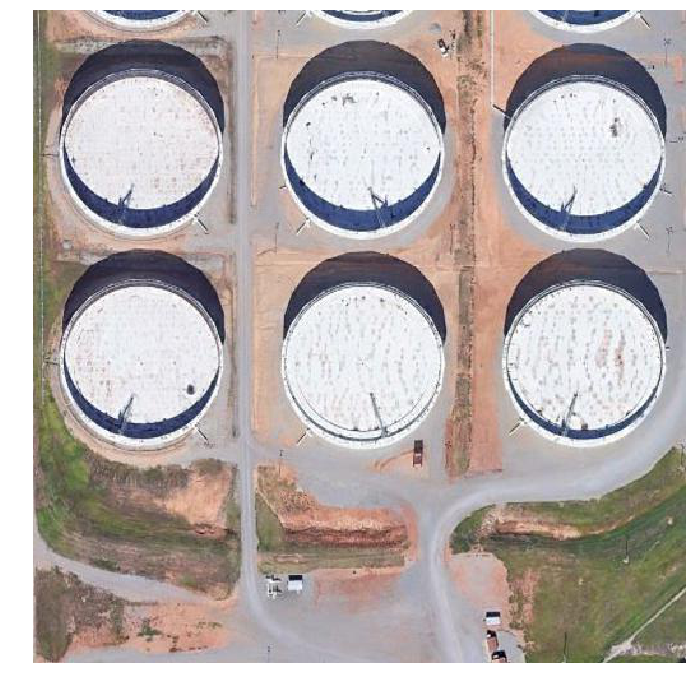

In [0]:
im = open_image(path/f'image_patches/{fname}')
im.show(figsize=(12,12))

In [0]:
tank = MultiTank(j[idx]['label']['Floating Head Tank'], im)

After processing, we can plot the tank volumes and their volume estimates

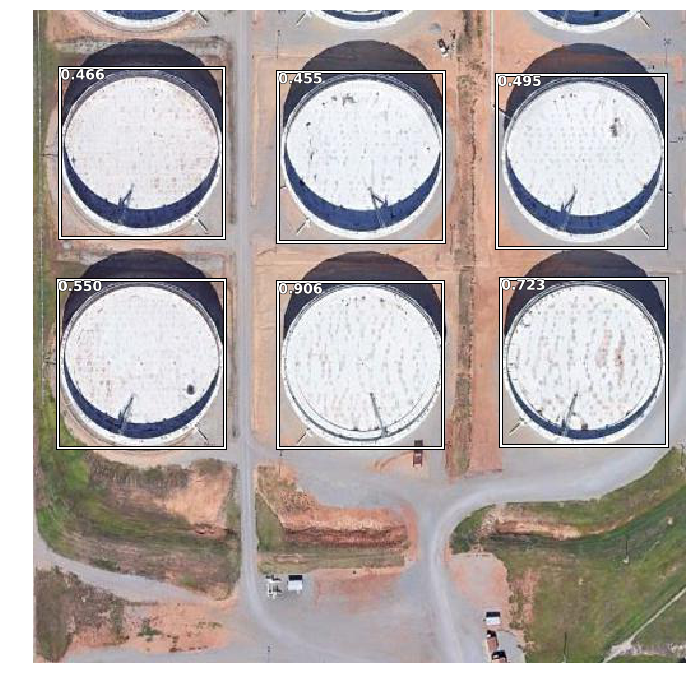

In [0]:
tank.plot_volumes(figsize=(12,12));

These are the contours of the extracted shadows

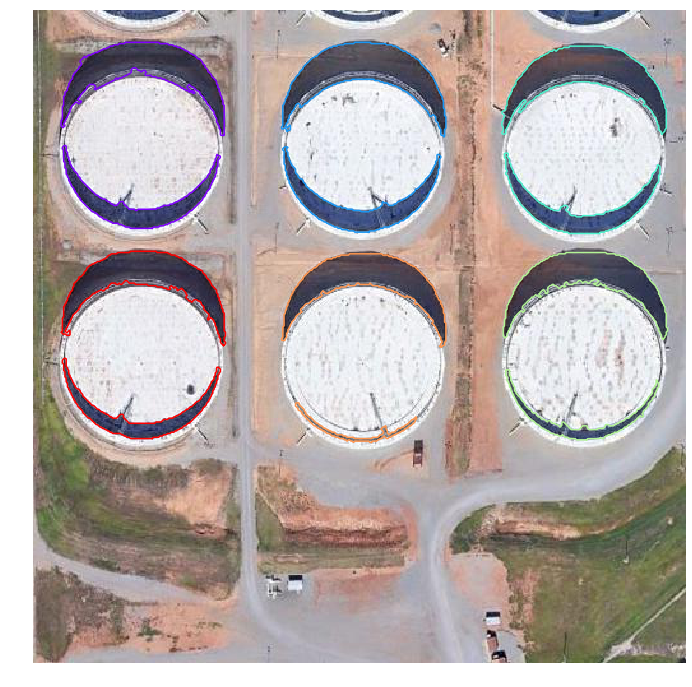

In [0]:
tank.plot_contours()

# How it Works

To see how the algorithm processes a tank, take a single tank in the previous image as an example

In [0]:
single_tank = tank.tanks[1]

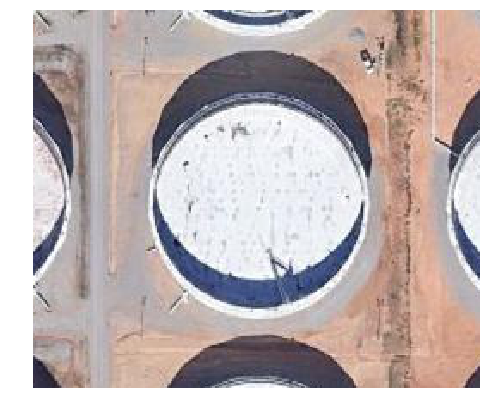

In [0]:
fig, axes = plt.subplots(figsize=(8,8))
axes.imshow(single_tank.tank_crop)
axes.axis('off');

We first create two versions of the image - one in HSV color space and one in LAB color space

In [0]:
hsv = color.rgb2hsv(single_tank.tank_crop)
H = hsv[:,:,0]
S = hsv[:,:,1]
V = hsv[:,:,2]

lab = color.rgb2lab(single_tank.tank_crop)
l1 = lab[:,:,0]
l2 = lab[:,:,1]
l3 = lab[:,:,2]

These are the channels from the converted images. Note which channels show a strong contrast between shadow regions and non-shadow regions 

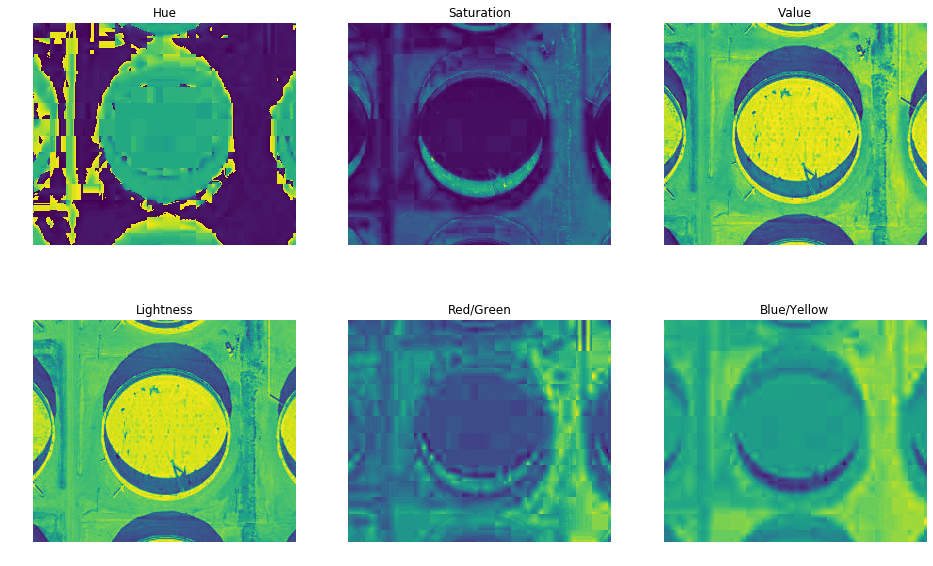

In [0]:
fig, axes = plt.subplots(2, 3, figsize=(16,10))

axes[0][0].imshow(H)
axes[0][0].set_title('Hue')

axes[0][1].imshow(S)
axes[0][1].set_title('Saturation')

axes[0][2].imshow(V)
axes[0][2].set_title('Value')

axes[1][0].imshow(l1)
axes[1][0].set_title('Lightness')

axes[1][1].imshow(l2)
axes[1][1].set_title('Red/Green')

axes[1][2].imshow(l3)
axes[1][2].set_title('Blue/Yellow');

for ax in axes.flat:
    ax.axis('off')

Many methods have been proposed for ratioing these channels to enhance shadows. The NSVDI algorithm proposes $\frac{S-V}{S+V}$. The paper [Estimating the Volume of Oil Tanks Based on High-Resolution Remote Sensing](https://www.mdpi.com/2072-4292/11/7/793/pdf) which explicitly deals with oil tanks suggests $\frac{H+1}{V+1}$.

I found the $\frac{H+1}{V+1}$ was thrown off by strong artifacts in the H channel, likely due to the source images being RGB jpeg images saved from Google Earth rather than real high resolution satellite photography. The $\frac{S-V}{S+V}$ method worked well on some images but failed on others.

Experimentally I found the ratio $\frac{-(l1 + l3)}{V + 1}$ worked well, where $l1$ and $l3$ are the first and third channels of the LAB color space image.

In [0]:
c1 = (H+1)/(V+1)
c2 = (S-V)/(S+V)
c3 = -(l1+l3)/(V+1)

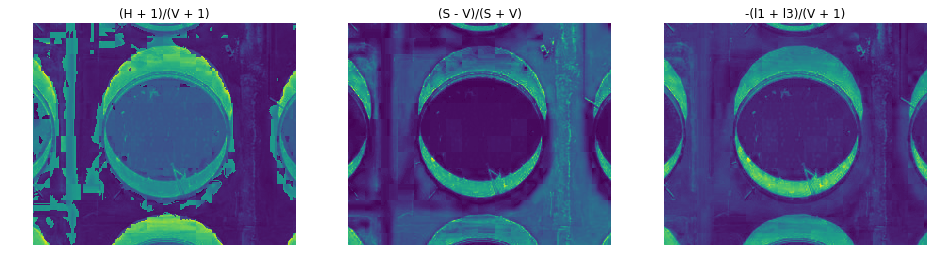

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes[0].imshow(c1)
axes[0].set_title('(H + 1)/(V + 1)')
axes[1].imshow(c2)
axes[1].set_title('(S - V)/(S + V)')
axes[2].imshow(c3)
axes[2].set_title('-(l1 + l3)/(V + 1)');

for ax in axes.flat:
    ax.axis('off')

The enhanced image is filtered by thresholding. I found the minimum threshold was often too stringent, while the mean threshold was too permissive. a combination of `0.6 * minimum_threshold + 0.4 * mean_threshold` works well

In [0]:
t1 = filters.threshold_minimum(c3)
t2 = filters.threshold_mean(c3)

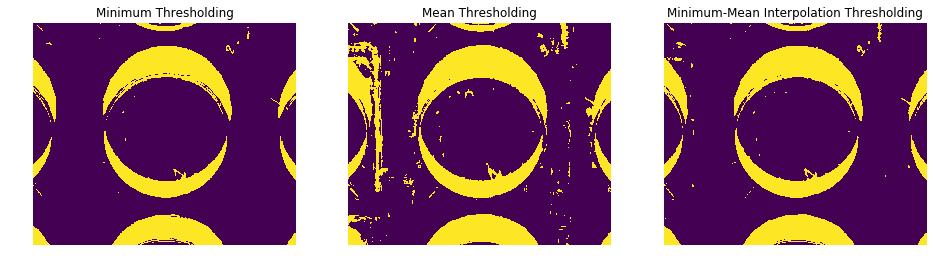

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes[0].imshow(c3 > t1)
axes[0].set_title('Minimum Thresholding')
axes[1].imshow(c3 > t2)
axes[1].set_title('Mean Thresholding')
axes[2].imshow(c3 > (0.6*t1 + 0.4*t2))
axes[2].set_title('Minimum-Mean Interpolation Thresholding')

for ax in axes.flat:
    ax.axis('off')

The thresholded image is then processed with morphological operations. These operations are:

* 1. Hessian Filter - cleans up noise and line artifacts from white pipes which appear in many images
* 2. Clear Border - clears contours from surrounding tanks
* 3. Morphological Closing - helps separate shapes
* 4. Area Closing - fills small holes
* 5. Morphological Labeling - labels features

In [0]:
tank_thresh = c3 > (0.6*t1 + 0.4*t2)

label_1 = filters.hessian(tank_thresh)
label_2 = segmentation.clear_border(filters.hessian(tank_thresh))
label_3 = morphology.closing(segmentation.clear_border(filters.hessian(tank_thresh)))
label_4 = morphology.area_closing(morphology.closing(segmentation.clear_border(filters.hessian(tank_thresh))))
label_image = measure.label(morphology.area_closing(morphology.closing(
            segmentation.clear_border(filters.hessian(tank_thresh)))))

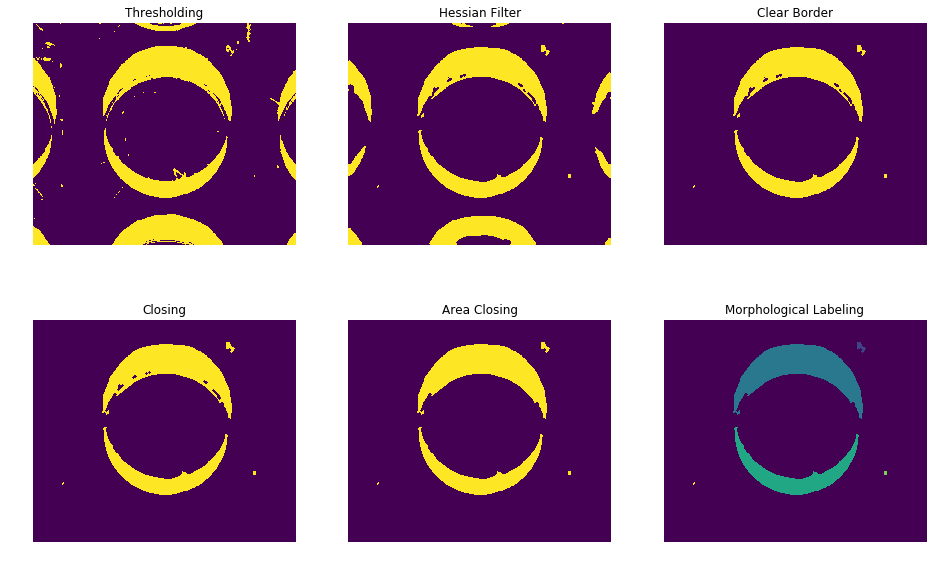

In [0]:
fig, axes = plt.subplots(2, 3, figsize=(16,10))

axes[0][0].imshow(tank_thresh)
axes[0][0].set_title('Thresholding')
axes[0][1].imshow(label_1)
axes[0][1].set_title('Hessian Filter')
axes[0][2].imshow(label_2)
axes[0][2].set_title('Clear Border')
axes[1][0].imshow(label_3)
axes[1][0].set_title('Closing')
axes[1][1].imshow(label_4)
axes[1][1].set_title('Area Closing')
axes[1][2].imshow(label_image)
axes[1][2].set_title('Morphological Labeling')

for ax in axes.flat:
    ax.axis('off')

We then filter the regions present by certain heuristics. The bounding box of the feature should intersect the bounding box of the tank. The feature should have an area of more than 25 pixels. The pixel coverate of the labeled image should be approximately the same as in the threshold image.

The first two clear up small artifacts. The third deals with the fact that the Hessian filter sometimes creates regions in spaces that are otherwise empty.

In [0]:
regions_all = measure.regionprops(label_image)
regions = []

for region in regions_all:
    if intersection(single_tank.bbox_relative, region.bbox) > 300:
        if region.area > 25:
            b = region.bbox
            if abs(tank_thresh[b[0]:b[2], b[1]:b[3]].mean() - region.image.mean()) < 0.06:
                regions.append(region)

We extract the two tank shadow contours

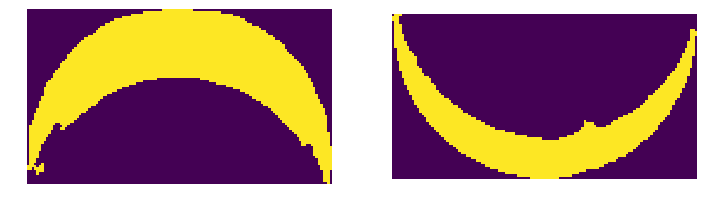

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(regions[0].image)
axes[1].imshow(regions[1].image)
for ax in axes.flat:
    ax.axis('off')

Volume is estimated as 1 minus the ratio of the smaller area to the larger area. The larger area corresponds to the exterior shadow of the tank, while the smaller area corresponds to the interior shadow.

In [0]:
areas = np.array([i.area for i in regions])
idx2, idx1 = areas.argsort()[-2:]
volume = 1 - regions[idx2].area / regions[idx1].area
print(volume)

0.45527584359935724


We create a clean mask by putting just the selected contours on a blank image

In [0]:
blank = np.zeros(single_tank.tank_crop.shape[:2])
for r in regions:
    y_min, x_min, y_max, x_max = r.bbox
    blank[y_min:y_max, x_min:x_max] += r.image.astype('uint8')

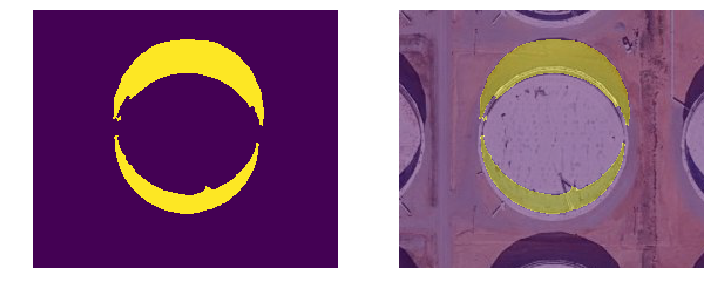

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(blank)
axes[1].imshow(single_tank.tank_crop)
axes[1].imshow(blank, alpha=0.5)
for ax in axes.flat:
    ax.axis('off')

We extract the contours from the mask

In [0]:
contours = measure.find_contours(blank, 0.5)

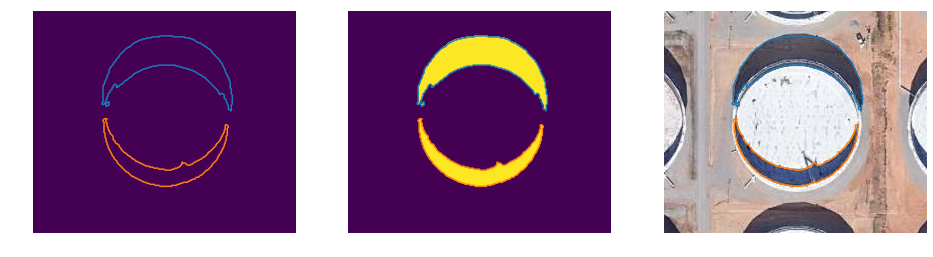

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(16,10))
axes[0].imshow(np.zeros(blank.shape))
axes[1].imshow(blank)
axes[2].imshow(single_tank.tank_crop)

for ax in axes:
    for c in contours:
        ax.plot(c[:,1], c[:,0])
        
for ax in axes.flat:
    ax.axis('off')